In [1]:
# From: https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

# Load Libraries and Sales Data

In [2]:
import warnings, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import statsmodels.api as sm

plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['text.color'] = 'k'

from fbprophet import Prophet

In [3]:
df = pd.read_excel('superstore_data.xls')
furniture_df = df.loc[df['Category'] == 'Furniture']
furniture_df = furniture_df.groupby('Order Date')['Sales'].sum().reset_index()
furniture_df = furniture_df.set_index('Order Date')
furniture_df.head()

,Sales
Order Date,
2014-01-06,2573.820
2014-01-07,76.728
2014-01-10,51.940
2014-01-11,9.940
2014-01-13,879.939


In [4]:
y = furniture_df['Sales'].resample('MS').mean() # 'MS' for start of month, 'M' for end of month
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

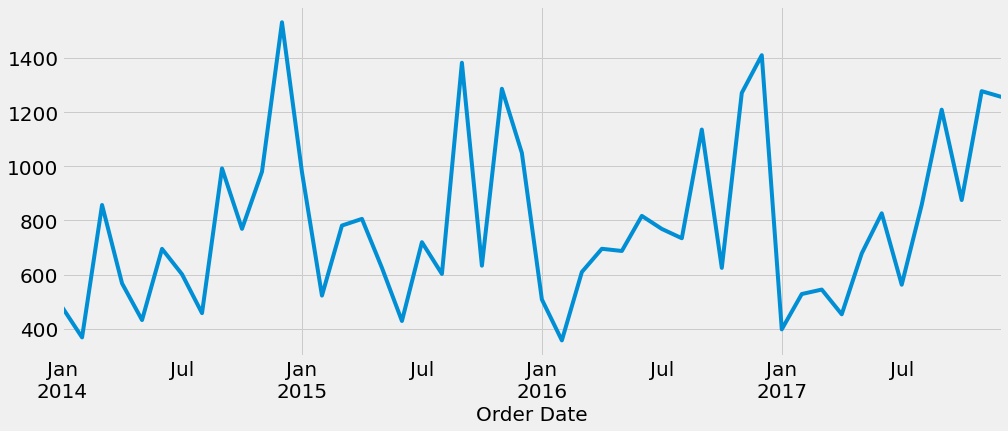

In [5]:
y.plot(figsize=(15,6));

# EDA

In [6]:
furniture_df = df.loc[df['Category'] == 'Furniture'] # for furniture sales
office_df = df.loc[df['Category'] == 'Office Supplies'] # for office sales
furniture_df.shape, office_df.shape

((2121, 21), (6026, 21))

In [7]:
# orders the dataframe by Order Date
furniture_df = furniture_df.sort_values('Order Date')
office_df = office_df.sort_values('Order Date')

In [8]:
# groupby Order Date
furniture_df = furniture_df.groupby('Order Date').sum()['Sales'].reset_index()
office_df = office_df.groupby('Order Date')['Sales'].sum().reset_index()

In [9]:
# set index on order date
furniture_df = furniture_df.set_index('Order Date')
office_df = office_df.set_index('Order Date')

In [10]:
# average sales by month, date set to 'MS' for start of each month
y_furn = furniture_df['Sales'].resample('MS').mean() # 'MS' means start of each month
y_office = office_df['Sales'].resample('MS').mean() 

In [11]:
# make combined data frames for y_furn and y_office
store_df = pd.DataFrame({'Order_Date': y_furn.index
                         , 'furniture_sales': y_furn.values
                         , 'office_sales': y_office.values
                        })
store_df.head()

,Order_Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


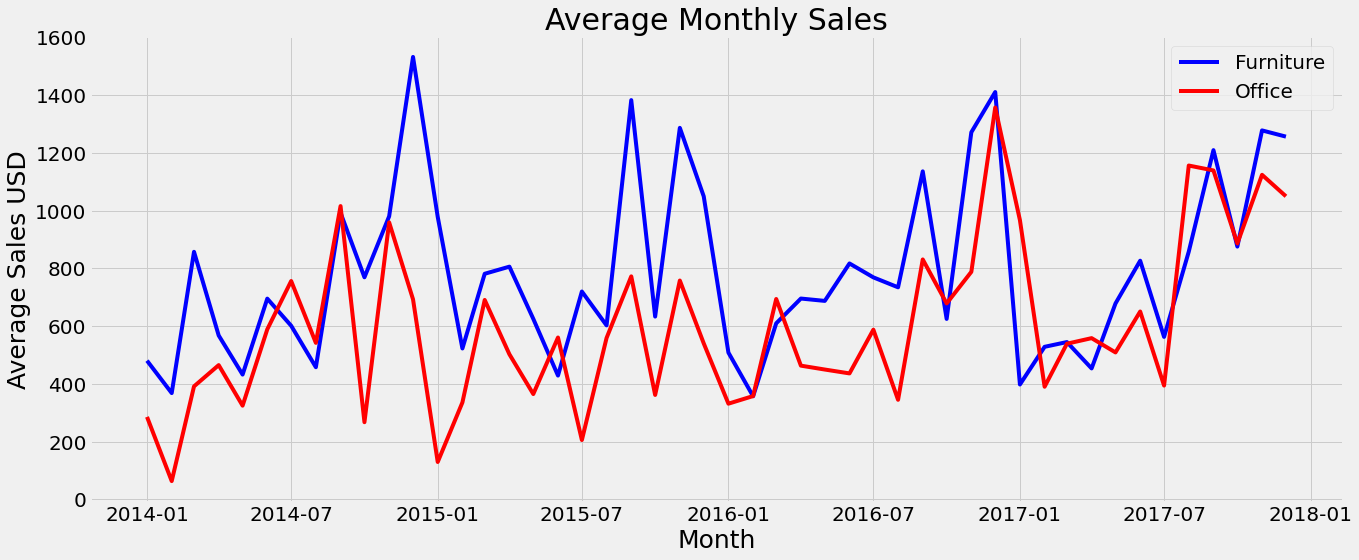

In [12]:
# Plot furniture and office sales
plt.figure(figsize=(20,8))
plt.plot(store_df.Order_Date
         , store_df.furniture_sales
         , 'b-'
         , label = 'Furniture'
        )
plt.plot(store_df.Order_Date
         , store_df.office_sales
         , 'r-'
         , label = 'Office'
        )
plt.legend(fontsize=20)
plt.title('Average Monthly Sales', fontsize=30)
plt.xlabel('Month', fontsize=25)
plt.ylabel('Average Sales USD', fontsize=25);

# Prophet Modeling 

In [13]:
furniture_df = df.loc[df['Category'] == 'Furniture'] # for furniture sales
office_df = df.loc[df['Category'] == 'Office Supplies'] # for office sales

furniture_df = furniture_df.sort_values('Order Date')
office_df = office_df.sort_values('Order Date')

furniture_df = furniture_df.groupby('Order Date').sum()['Sales'].reset_index()
office_df = office_df.groupby('Order Date')['Sales'].sum().reset_index()

In [14]:
from fbprophet import Prophet

In [15]:
furniture_df.head()

,Order Date,Sales
0,2014-01-06,2573.820
1,2014-01-07,76.728
2,2014-01-10,51.940
3,2014-01-11,9.940
4,2014-01-13,879.939


In [16]:
# Relabel columns
furniture_df = furniture_df.rename(columns = {'Order Date': 'ds'
                                              , 'Sales': 'y'
                                             })
furniture_df

,ds,y
0,2014-01-06,2573.8200
1,2014-01-07,76.7280
2,2014-01-10,51.9400
3,2014-01-11,9.9400
4,2014-01-13,879.9390
...,...,...
884,2017-12-24,1393.4940
885,2017-12-25,832.4540
886,2017-12-28,551.2568
887,2017-12-29,2330.7180


In [17]:
# Fit furniture data
furniture_model = Prophet(interval_width = 0.95)
furniture_model.fit(furniture_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [18]:
# Relabel columns
office_df = office_df.rename(columns = {'Order Date': 'ds'
                                         , 'Sales': 'y'
                                        })
office_df

,ds,y
0,2014-01-03,16.448
1,2014-01-04,288.060
2,2014-01-05,19.536
3,2014-01-06,685.340
4,2014-01-07,10.430
...,...,...
1143,2017-12-26,814.594
1144,2017-12-27,13.248
1145,2017-12-28,1091.244
1146,2017-12-29,282.440


In [19]:
# Fit office data
office_model = Prophet(interval_width = 0.95)
office_model.fit(office_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [20]:
# Forecasts
furniture_forecast = furniture_model.make_future_dataframe(periods = 36
                                                           , freq = 'MS'
                                                          )
furniture_forecast = furniture_model.predict(furniture_forecast)

office_forecast = office_model.make_future_dataframe(periods = 36
                                                     , freq = 'MS'
                                                    )
office_forecast = office_model.predict(office_forecast)

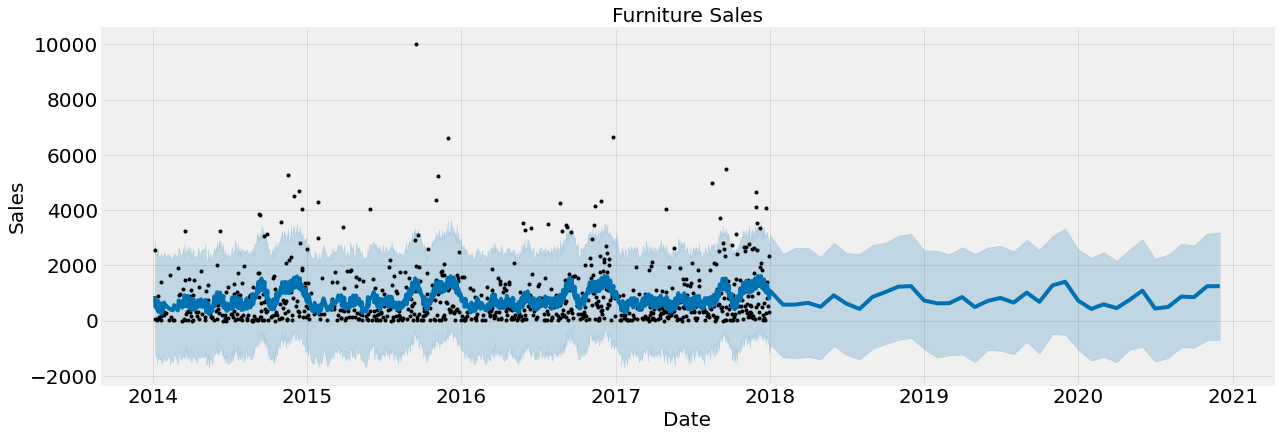

In [24]:
# Plot Furniture
furniture_model.plot(furniture_forecast
                     , xlabel = 'Date'
                     , ylabel = 'Sales'
                     , figsize = (18, 6)
                    )
plt.title('Furniture Sales');

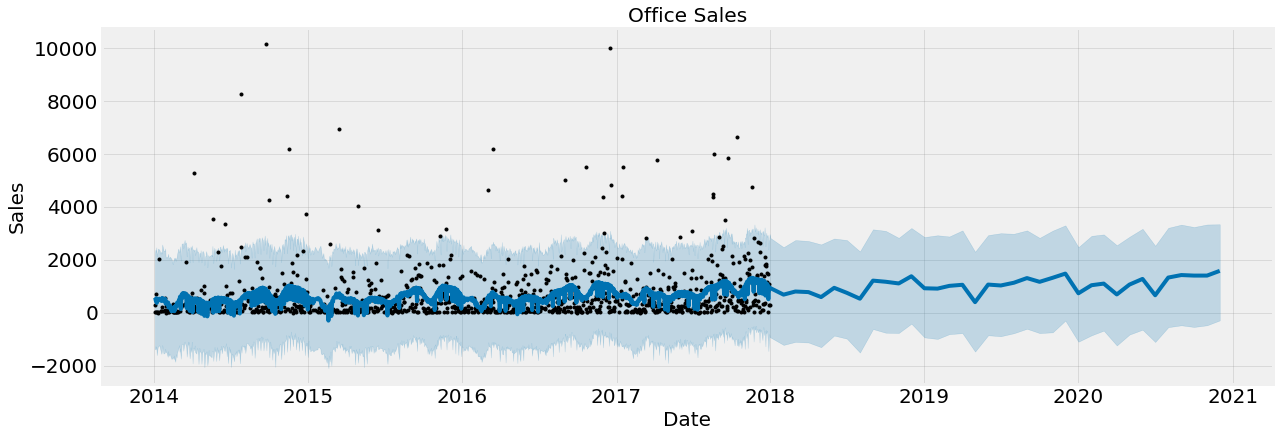

In [25]:
# Plot Office
office_model.plot(office_forecast
                  , xlabel = 'Date'
                  , ylabel = 'Sales'
                  , figsize = (18, 6)
                 )
plt.title('Office Sales');